In [15]:
import bamboolib as bam
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.4f}'.format)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import shap
import tensorflow as tf

In [16]:
df = pd.read_excel(r'C:\Users\ParsArgham\Desktop\Univercity\Papers\#J A Variation-Aware Decision Support System for Tackling COVID-19 A Transfer Learning and MADM Approach\data.xlsx')
# Step: Drop rows where variant is one of: B.1.427/B.1.429, B.1.525, B.1.621, C.37, SGTF, B.1.616, B.1.620, UNK, Other
df = df.loc[~(df['variant'].isin(['B.1.427/B.1.429', 'B.1.525', 'B.1.621', 'C.37', 'SGTF', 'B.1.616', 'B.1.620', 'UNK', 'Other']))]
# Step: Drop columns
df = df.drop(columns=['source', 'new_cases', 'number_sequenced', 'percent_cases_sequenced', 'valid_denominator', 'number_sequenced_known_variant', 'percent_variant'])

In [3]:
df2 = pd.read_csv(r'C:\Users\ParsArgham\Desktop\Univercity\Papers\#J A Variation-Aware Decision Support System for Tackling COVID-19 A Transfer Learning and MADM Approach\owid-covid-data.csv', sep=',', decimal='.')
# Step: Drop columns
df2 = df2.drop(columns=['iso_code', 'continent', 'new_cases_smoothed', 'total_cases', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_smoothed_per_million', 'new_cases_per_million', 'new_deaths_per_million', 'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'total_tests_per_thousand', 'new_tests_per_thousand', 'tests_per_case', 'new_vaccinations_smoothed', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred', 'new_people_vaccinated_smoothed', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed_per_hundred', 'total_boosters_per_hundred', 'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million'])
# Step: Change data type of date to Datetime
df2['date'] = pd.to_datetime(df2['date'], infer_datetime_format=True)
df2['year_week'] = df2['date'].dt.strftime('%Y-%U')
# Step: Group by and aggregate
df2 = df2.groupby(['location', 'year_week']).agg(new_cases=('new_cases', 'sum'), new_tests=('new_tests', 'sum'), reproduction_rate=('reproduction_rate', 'mean'), icu_patients=('icu_patients', 'sum'), hosp_patients=('hosp_patients', 'sum'), weekly_icu_admissions=('weekly_icu_admissions', 'sum'), weekly_hosp_admissions=('weekly_hosp_admissions', 'sum'), positive_rate=('positive_rate', 'mean'), total_vaccinations=('total_vaccinations', 'max'), people_vaccinated=('people_vaccinated', 'max'), people_fully_vaccinated=('people_fully_vaccinated', 'max'), stringency_index=('stringency_index', 'mean'), excess_mortality=('excess_mortality', 'mean'), population=('population', 'mean'), human_development_index=('human_development_index', 'mean'), life_expectancy=('life_expectancy', 'mean'), handwashing_facilities=('handwashing_facilities', 'mean'), male_smokers=('male_smokers', 'mean'), female_smokers=('female_smokers', 'mean'), diabetes_prevalence=('diabetes_prevalence', 'mean'), cardiovasc_death_rate=('cardiovasc_death_rate', 'mean'), gdp_per_capita=('gdp_per_capita', 'mean'), extreme_poverty=('extreme_poverty', 'mean'), aged_65_older=('aged_65_older', 'mean'), aged_70_older=('aged_70_older', 'mean'), median_age=('median_age', 'mean'), population_density=('population_density', 'mean')).reset_index()
df2 = df2.loc[df2['location'].isin(df['country'].unique())]
df2

      location year_week  new_cases  new_tests  reproduction_rate  \
3108   Austria   2020-00     7.0000     0.0000                NaN   
3109   Austria   2020-01 27818.0000     0.0000                NaN   
3110   Austria   2020-02     0.0000     0.0000                NaN   
3111   Austria   2020-03     0.0000     0.0000                NaN   
3112   Austria   2020-04     0.0000     0.0000                NaN   
...        ...       ...        ...        ...                ...   
48300   Sweden   2024-05     0.0000     0.0000                NaN   
48301   Sweden   2024-06     0.0000     0.0000                NaN   
48302   Sweden   2024-07   229.0000     0.0000                NaN   
48303   Sweden   2024-08     0.0000     0.0000                NaN   
48304   Sweden   2024-09     0.0000     0.0000                NaN   

       icu_patients  hosp_patients  weekly_icu_admissions  \
3108         0.0000         0.0000                 0.0000   
3109         0.0000         0.0000               

In [4]:
# Step: Left Join with df2 where year_week=year_week, country=location
df3 = pd.merge(df, df2.drop(columns=[]), how='left', left_on=['year_week', 'country'], right_on=['year_week', 'location'])


In [5]:
df3 = df3.groupby(['country', 'variant']).agg(number_detections_variant=('new_cases', 'sum'), new_tests=('new_tests', 'sum'), reproduction_rate=('reproduction_rate', 'mean'), icu_patients=('icu_patients', 'sum'), hosp_patients=('hosp_patients', 'sum'), weekly_icu_admissions=('weekly_icu_admissions', 'sum'), weekly_hosp_admissions=('weekly_hosp_admissions', 'sum'), positive_rate=('positive_rate', 'mean'), total_vaccinations=('total_vaccinations', 'max'), people_vaccinated=('people_vaccinated', 'max'), people_fully_vaccinated=('people_fully_vaccinated', 'max'), stringency_index=('stringency_index', 'mean'), excess_mortality=('excess_mortality', 'mean'), population=('population', 'mean'), human_development_index=('human_development_index', 'mean'), life_expectancy=('life_expectancy', 'mean'), handwashing_facilities=('handwashing_facilities', 'mean'), male_smokers=('male_smokers', 'mean'), female_smokers=('female_smokers', 'mean'), diabetes_prevalence=('diabetes_prevalence', 'mean'), cardiovasc_death_rate=('cardiovasc_death_rate', 'mean'), gdp_per_capita=('gdp_per_capita', 'mean'), extreme_poverty=('extreme_poverty', 'mean'), aged_65_older=('aged_65_older', 'mean'), aged_70_older=('aged_70_older', 'mean'), median_age=('median_age', 'mean'), population_density=('population_density', 'mean')).reset_index()

In [6]:
# Step: Drop columns
df_final = df3.drop(columns=['handwashing_facilities'])
df_final.replace(0, np.nan, inplace=True)
# Step: Replace missing values
df_final = df_final.fillna(df3.median())
df_final

     country  variant  number_detections_variant       new_tests  \
0    Austria    Alpha               8215360.0000  380601919.0000   
1    Austria     Beta               6319610.0000  234780934.0000   
2    Austria    Delta              11012097.0000  410989446.0000   
3    Austria    Gamma              12543741.0000  433752017.0000   
4    Austria  Omicron              88383937.0000 2360014606.0000   
..       ...      ...                        ...             ...   
145   Sweden    Alpha               3897004.0000   31547783.0000   
146   Sweden     Beta               3317118.0000   24954731.0000   
147   Sweden    Delta               4420049.0000   32027001.0000   
148   Sweden    Gamma               5991815.0000   42625752.0000   
149   Sweden  Omicron              36814696.0000  224497397.0000   

     reproduction_rate  icu_patients  hosp_patients  weekly_icu_admissions  \
0               1.0538   347907.0000   2098773.0000              1318.0000   
1               1.0572   25

1/1 [==============================] - 0s 54ms/step


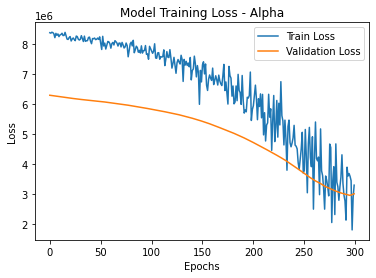

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/27 [00:00<?, ?it/s]

85/85 [==============================] - 0s 934us/step


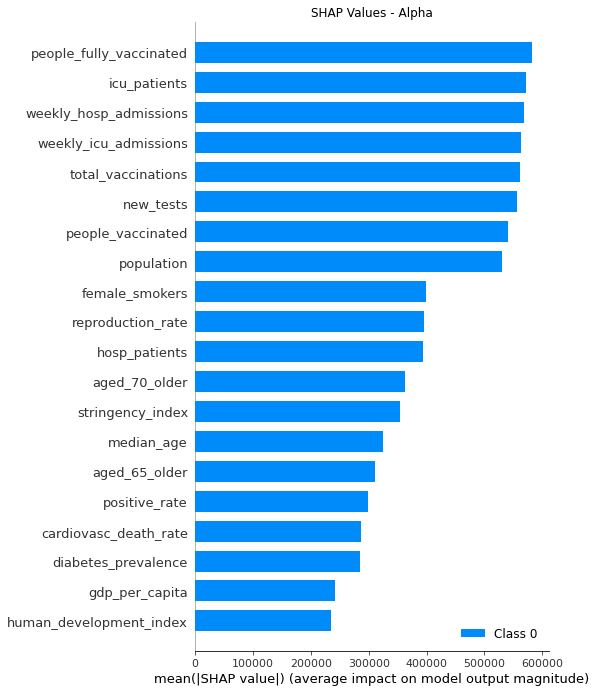

1/1 [==============================] - 0s 57ms/step


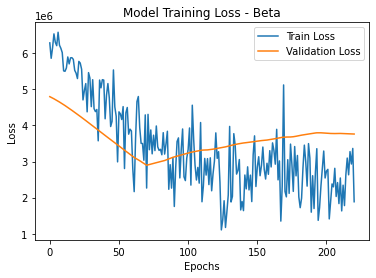

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/27 [00:00<?, ?it/s]

85/85 [==============================] - 0s 958us/step


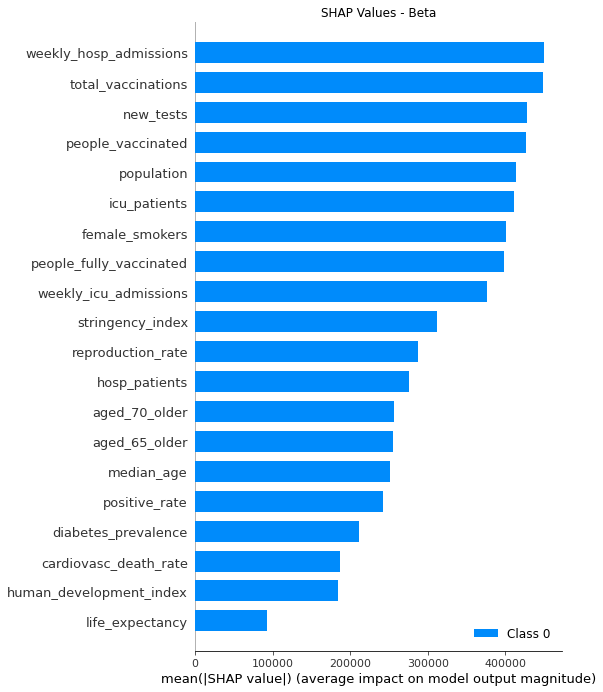

1/1 [==============================] - 0s 56ms/step


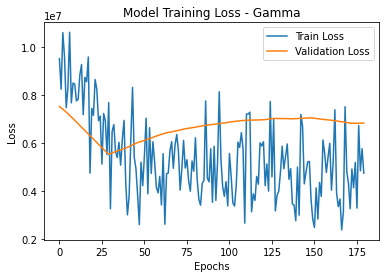

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/27 [00:00<?, ?it/s]

85/85 [==============================] - 0s 877us/step


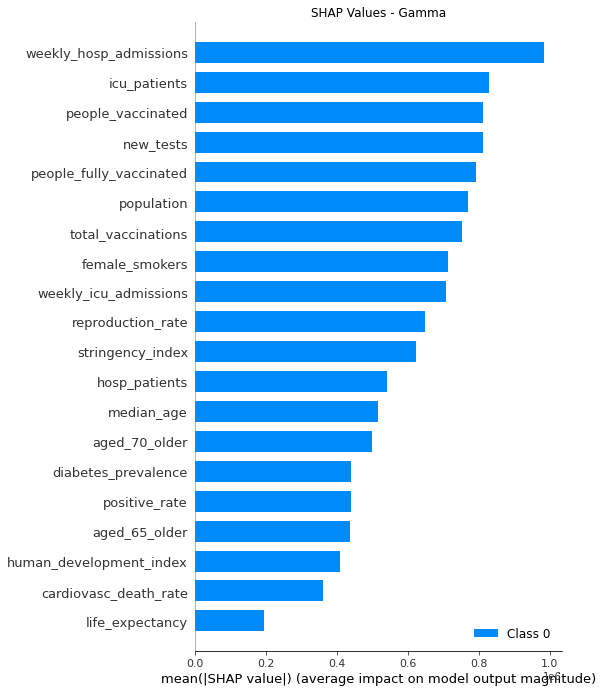

1/1 [==============================] - 0s 54ms/step


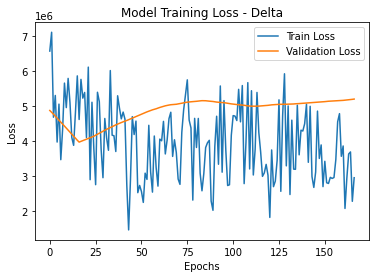

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/27 [00:00<?, ?it/s]

85/85 [==============================] - 0s 774us/step


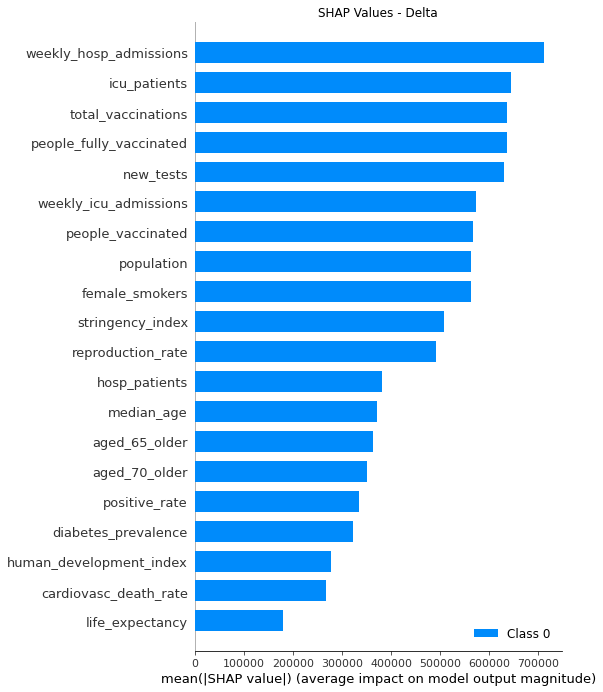

1/1 [==============================] - 0s 57ms/step


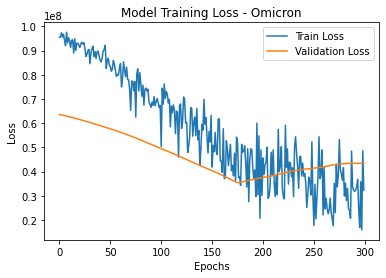

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/27 [00:00<?, ?it/s]

85/85 [==============================] - 0s 932us/step


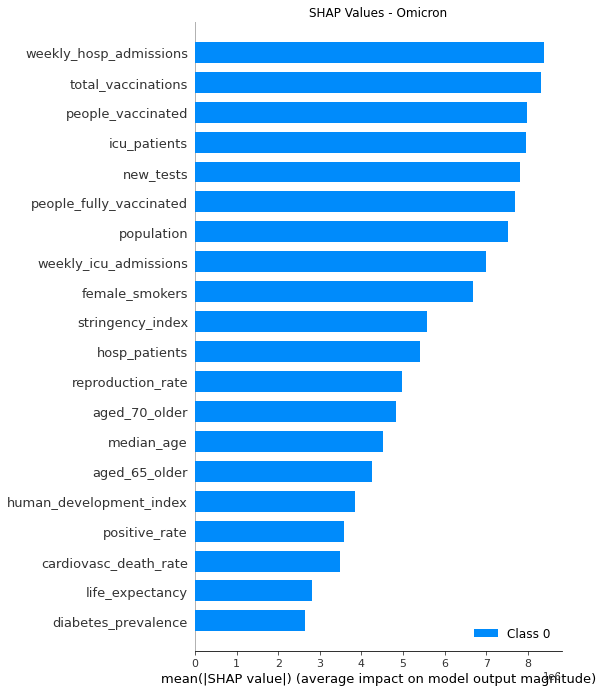

Results with Transfer Learning:
   Variant           MAE                   MSE          RMSE
0    Alpha  3125082.5479   34836999738254.8984  4381420.6508
1     Beta  2736003.1958   28565633048668.2930  3912237.4836
2    Gamma  5135502.2082   86162363661281.5312  6981456.6795
3    Delta  3992970.9996   63241661533989.4844  5654557.1631
4  Omicron 33699864.0976 3890865123209482.5000 46367353.2591


In [18]:
# Set a fixed random state
random_state = 42

# Define the variants
variants = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

# Initialize empty tables to store results
results_transfer_learning = pd.DataFrame(columns=['Variant', 'MAE', 'MSE', 'RMSE'])

# Define EarlyStopping callback with fixed random state
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)

# Define the number of folds for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Define the model creation function
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001), input_shape=input_shape),
        layers.Dropout(0.6),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
        layers.Dropout(0.6),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    custom_optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=custom_optimizer, loss='mean_absolute_error')
    return model

# Iterate through each variant
for i in range(len(variants)):
    current_variant = variants[i]
    previous_variant = variants[i-1] if i > 0 else None

    # Filter the dataset for the current variant
    df_variant = df_final[df_final['variant'] == current_variant]

    # Split the dataset into features and target
    X = df_variant.drop(['variant', 'country', 'number_detections_variant'], axis=1)
    y = df_variant['number_detections_variant']

    # Initialize lists to store metrics for each fold
    fold_mae = []
    fold_mse = []
    fold_rmse = []

    # Cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Load the previous model if transfer learning is applicable
        if i > 0:
            previous_model = keras.models.clone_model(model)
            previous_model.set_weights(model.get_weights())

        # Create and compile the model
        model = create_model((X_train.shape[1],))

        # Train the model with EarlyStopping callback
        history = model.fit(X_train, y_train, epochs=300, validation_split=0.3, callbacks=[early_stopping], verbose=0)

        # Transfer weights from the previous model if applicable
        if i > 0:
            model.layers[0].set_weights(previous_model.layers[0].get_weights())
            model.layers[1].set_weights(previous_model.layers[1].get_weights())

        # Train the model with EarlyStopping callback
        history_transfer_learning = model.fit(X_train, y_train, epochs=300, validation_split=0.3, callbacks=[early_stopping], verbose=0)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_mse.append(mean_squared_error(y_test, y_pred))
        fold_rmse.append(math.sqrt(mean_squared_error(y_test, y_pred)))

    # Calculate mean metrics across all folds
    mae_transfer_learning = np.mean(fold_mae)
    mse_transfer_learning = np.mean(fold_mse)
    rmse_transfer_learning = np.mean(fold_rmse)

    # Add results to the table
    results_transfer_learning = results_transfer_learning.append({
        'Variant': current_variant,
        'MAE': mae_transfer_learning,
        'MSE': mse_transfer_learning,
        'RMSE': rmse_transfer_learning
    }, ignore_index=True)

    # Plot train and validation loss
    plt.plot(history_transfer_learning.history['loss'], label='Train Loss')
    plt.plot(history_transfer_learning.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Training Loss - {current_variant}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Explain the model using SHAP values
    explainer = shap.KernelExplainer(model.predict, X_train)
    shap_values = explainer.shap_values(X_train, nsamples=100)

    # Create a summary plot for each model
    shap.summary_plot(shap_values, X_train, feature_names=df_variant.drop(['variant', 'country', 'number_detections_variant'], axis=1).columns, plot_type='bar', show=False)
    plt.title(f'SHAP Values - {current_variant}')
    plt.savefig(f'shap_plot_{current_variant}.png', dpi=300)  # Save the plot with 300 DPI
    plt.show()

# Display the results
print("Results with Transfer Learning:")
print(results_transfer_learning)


In [21]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

# Set a fixed random state
random_state = 42

# Define the variants
variants = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

# Initialize empty table to store results
results_no_transfer_learning = pd.DataFrame(columns=['Variant', 'MAE', 'MSE', 'RMSE'])

# Define EarlyStopping callback with fixed random state
early_stopping = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)

# Define the number of folds for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Define the model creation function
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001), input_shape=input_shape),
        layers.Dropout(0.6),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
        layers.Dropout(0.6),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    custom_optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=custom_optimizer, loss='mean_absolute_error')
    return model

# Iterate through each variant
for current_variant in variants:
    # Filter the dataset for the current variant
    df_variant = df_final[df_final['variant'] == current_variant]

    # Split the dataset into features and target
    X = df_variant.drop(['variant', 'country', 'number_detections_variant'], axis=1)
    y = df_variant['number_detections_variant']

    # Initialize lists to store metrics for each fold
    fold_mae = []
    fold_mse = []
    fold_rmse = []

    # Cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Create and compile the model
        model = create_model((X_train.shape[1],))

        # Train the model with EarlyStopping callback
        model.fit(X_train, y_train, epochs=300, validation_split=0.3, callbacks=[early_stopping], verbose=0)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        fold_mae.append(mean_absolute_error(y_test, y_pred))
        fold_mse.append(mean_squared_error(y_test, y_pred))
        fold_rmse.append(math.sqrt(mean_squared_error(y_test, y_pred)))

    # Calculate mean metrics across all folds
    mae_no_transfer_learning = np.mean(fold_mae)
    mse_no_transfer_learning = np.mean(fold_mse)
    rmse_no_transfer_learning = np.mean(fold_rmse)

    # Add results to the table
    results_no_transfer_learning = results_no_transfer_learning.append({
        'Variant': current_variant,
        'MAE': mae_no_transfer_learning,
        'MSE': mse_no_transfer_learning,
        'RMSE': rmse_no_transfer_learning
    }, ignore_index=True)

# Display the results
print("Results without Transfer Learning:")
print(results_no_transfer_learning)


1/1 [==============================] - 0s 55ms/step
Results without Transfer Learning:
   Variant           MAE                    MSE           RMSE
0    Alpha  7085688.4078   194777433931870.0312  10567464.1471
1     Beta  6315651.1328   154804758974755.9375   9368524.9034
2    Gamma 12279910.2760   574019783996581.8750  18078069.7824
3    Delta  9111414.5224   325626436466515.3125  13431780.6044
4  Omicron 85570949.5940 28717687005037884.0000 125918857.7038
